# Bayesian optimisation of Hyperparameters

## Imports

In [14]:
from ConfigSpace import Configuration, ConfigurationSpace
from ConfigSpace.hyperparameters import (
    UniformFloatHyperparameter,
    UniformIntegerHyperparameter,
    OrdinalHyperparameter
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from smac import MultiFidelityFacade as MFFacade
from smac import Scenario
from smac.intensifier.hyperband import Hyperband
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from time import time

## Data loading and preprocessing

In [9]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# --- Global Data Loading and Preprocessing ---
df = pd.read_csv('spam.csv', sep="\t", encoding='latin-1', names=['label', 'message'])

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

X = df['message']
y = df['label']

# Constants for preprocessing
MAX_WORDS = 1000
MAX_LEN = 150

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN)

# Split data (Held globally to avoid re-splitting every iteration)
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

## Manual One-Factor-At-A-Time (OFAT) strategy

### Functions definition

In [12]:
# --- Modular Training Function ---
def train_lstm(dropout_rate, num_layers, embedding_dim, units, learning_rate):
    """
    Builds and trains an LSTM model with specific hyperparameters.
    Returns the validation loss.
    """
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim))

    # LSTM Layers handling
    # If multiple layers, intermediate layers need return_sequences=True
    if num_layers > 1:
        for _ in range(num_layers - 1):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))

    # Final (or only) LSTM layer
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile with custom Learning Rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train
    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.2,
                        verbose=0)

    # Return the final validation loss from the last epoch
    final_val_loss = history.history['val_loss'][-1]
    return final_val_loss

# --- Sweep and Plot Function ---
def get_sweep(defaults, param_name, values):
    """
    Sweeps a single hyperparameter while keeping others at default.
    Generates and shows an elbow curve plot for that specific parameter.
    """
    losses = []
    print(f"\n--- Sweeping {param_name} ---")

    for val in values:
        # Copy defaults and update the target parameter
        current_params = defaults.copy()
        current_params[param_name] = val

        print(f"Testing {param_name} = {val}...", end=" ")

        loss = train_lstm(
            dropout_rate=current_params['dropout_rate'],
            num_layers=current_params['num_layers'],
            embedding_dim=current_params['embedding_dim'],
            units=current_params['units'],
            learning_rate=current_params['learning_rate']
        )
        losses.append(loss)
        print(f"Loss: {loss:.4f}")

    # Plotting the elbow curve for this parameter
    plt.figure(figsize=(8, 5))
    plt.plot(values, losses, marker='o', linestyle='-', color='b')
    plt.title(f'Elbow Curve: Effect of {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Validation Loss')
    plt.grid(True)

    # Log scale for Learning Rate for better visualization
    if param_name == 'learning_rate':
        plt.xscale('log')

    plt.show()

### Execution

Starting Hyperparameter Optimization...

--- Sweeping dropout_rate ---
Testing dropout_rate = 0.1... Loss: 0.0952
Testing dropout_rate = 0.2... Loss: 0.0937
Testing dropout_rate = 0.3... Loss: 0.0993
Testing dropout_rate = 0.4... Loss: 0.0914
Testing dropout_rate = 0.5... Loss: 0.1100
Testing dropout_rate = 0.6... Loss: 0.1028


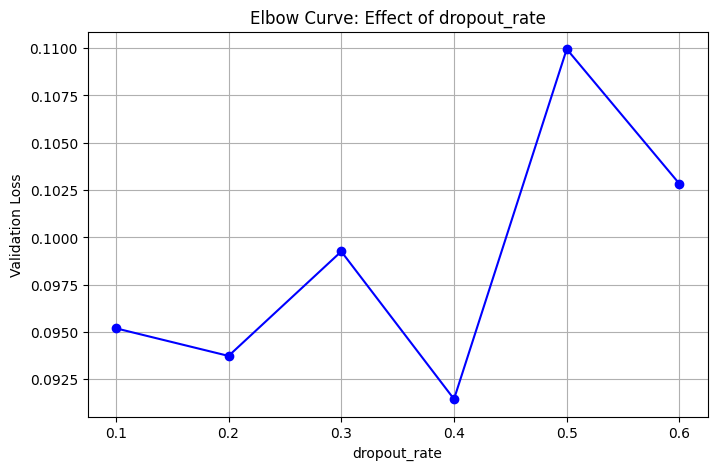


--- Sweeping num_layers ---
Testing num_layers = 1... Loss: 0.0966
Testing num_layers = 2... Loss: 0.1296
Testing num_layers = 3... Loss: 0.1222


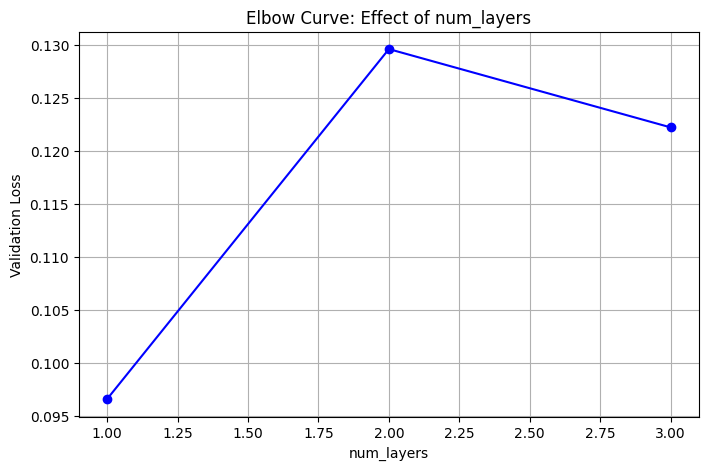


--- Sweeping embedding_dim ---
Testing embedding_dim = 20... Loss: 0.0932
Testing embedding_dim = 30... Loss: 0.0901
Testing embedding_dim = 40... Loss: 0.0883
Testing embedding_dim = 50... Loss: 0.0995
Testing embedding_dim = 60... Loss: 0.0860
Testing embedding_dim = 70... Loss: 0.0806
Testing embedding_dim = 80... Loss: 0.0953
Testing embedding_dim = 90... Loss: 0.0937
Testing embedding_dim = 100... Loss: 0.0945
Testing embedding_dim = 125... Loss: 0.0984
Testing embedding_dim = 150... Loss: 0.1074
Testing embedding_dim = 175... Loss: 0.0854
Testing embedding_dim = 200... Loss: 0.1087


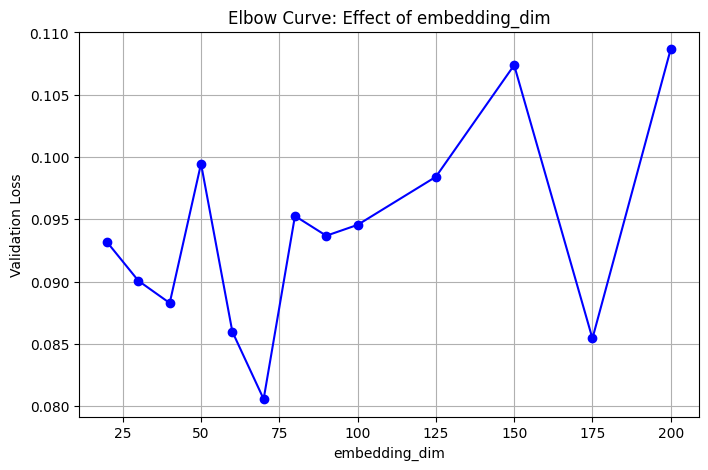


--- Sweeping units ---
Testing units = 16... Loss: 0.0890
Testing units = 20... Loss: 0.0827
Testing units = 24... Loss: 0.0669
Testing units = 28... Loss: 0.1021
Testing units = 32... Loss: 0.1025
Testing units = 40... Loss: 0.1056
Testing units = 48... Loss: 0.1033
Testing units = 56... Loss: 0.1065
Testing units = 64... Loss: 0.1075
Testing units = 80... Loss: 0.1060
Testing units = 96... Loss: 0.1114
Testing units = 112... Loss: 0.1050
Testing units = 128... Loss: 0.0679


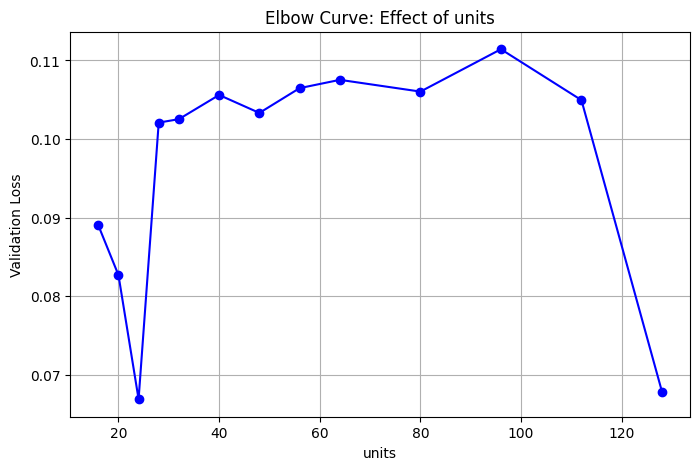


--- Sweeping learning_rate ---
Testing learning_rate = 0.01... Loss: 0.1401
Testing learning_rate = 0.007... Loss: 0.1308
Testing learning_rate = 0.003... Loss: 0.1006
Testing learning_rate = 0.002... Loss: 0.0997
Testing learning_rate = 0.001... Loss: 0.0913
Testing learning_rate = 0.0007... Loss: 0.0897
Testing learning_rate = 0.0003... Loss: 0.0749
Testing learning_rate = 0.0002... Loss: 0.0932
Testing learning_rate = 0.0001... Loss: 0.1742


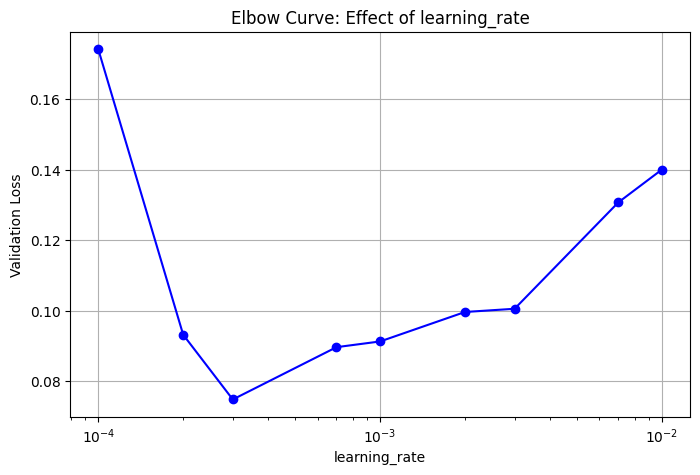

In [13]:
# Baseline defaults
defaults = {
    'dropout_rate': 0.5,
    'num_layers': 1,
    'embedding_dim': 50,
    'units': 32,
    'learning_rate': 0.001
}

print("Starting Hyperparameter Optimization...")

start = time()

# 1. Sweep Dropout
get_sweep(defaults, 'dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# 2. Sweep Number of Layers
get_sweep(defaults, 'num_layers', [1, 2, 3])

# 3. Sweep Embedding Dimension
get_sweep(defaults, 'embedding_dim', [20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200])

# 4. Sweep LSTM Units
get_sweep(defaults, 'units', [16, 20, 24, 28, 32, 40, 48, 56, 64, 80, 96, 112, 128])

# 5. Sweep Learning Rate
get_sweep(defaults, 'learning_rate', [0.01, 0.007, 0.003, 0.002, 0.001, 0.0007, 0.0003, 0.0002, 0.0001])

total_time = time() - start

In [16]:
# Validate the best model
best_loss = train_lstm(0.4, 1, 70, 24, 0.0003)

In [18]:
print(f"The total manual HPO took {total_time/60:.2f} minutes and had a loss of {best_loss:.4f}")

The total manual HPO took 57.90 minutes and had a loss of 0.0778


## Automatic HPO using `SMAC`

### Functions definition

In [21]:
# --- Target Function ---
def train_lstm_smac(config: Configuration, seed: int = 0, budget: float = 5) -> float:
    """
    The target function optimized by SMAC.

    Args:
        config: The hyperparameter configuration chosen by SMAC.
        seed: Random seed for reproducibility.
        budget: The 'fidelity' (resource) allocated. We map this to 'epochs'.

    Returns:
        The validation loss (to be minimized).
    """
    # Extract hyperparameters from the config object
    dropout_rate = float(config["dropout_rate"])
    num_layers = int(config["num_layers"])
    embedding_dim = int(config["embedding_dim"])
    units = int(config["units"])
    learning_rate = float(config["learning_rate"])

    # Explicitly set seed for this run
    tf.random.set_seed(seed)

    # Build Model
    model = Sequential()
    model.add(Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim))

    # Add LSTM layers based on num_layers
    if num_layers > 1:
        for _ in range(num_layers - 1):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))

    # Final LSTM layer
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train using 'budget' as the number of epochs
    # Multi-fidelity starts with small epochs and increases them for promising models
    epochs = int(budget)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,
        validation_split=0.2,
        verbose=0
    )

    # Return the final validation loss
    return history.history['val_loss'][-1]

### Execution

In [22]:
# --- Define Configuration Space & Run SMAC ---
start = time()

# Define the search space (ConfigSpace)
cs = ConfigurationSpace()

dropout = UniformFloatHyperparameter("dropout_rate", 0.1, 0.6)
layers = UniformIntegerHyperparameter("num_layers", 1, 3)
embedding = UniformIntegerHyperparameter("embedding_dim", 20, 200)

unit_choices = [16, 20, 24, 28, 32, 40, 48, 56, 64, 80, 96, 112, 128]
units = OrdinalHyperparameter("units", unit_choices)

lr = UniformFloatHyperparameter("learning_rate", 0.0001, 0.01, log=True)

cs.add([dropout, layers, embedding, units, lr])

# Define the Scenario
scenario = Scenario(
    cs,
    deterministic=True,  # Set False if the training is inherently noisy even with seeds
    n_trials=90,         # Total number of configurations to try
    min_budget=1,        # Minimum epochs
    max_budget=10,       # Maximum epochs
)

print("Starting SMAC optimization...")
print(f"Search Space Size: Infinite (Continuous)")
print(f"Budget: 1 to 10 epochs per trial")

# eta=3 means only the top 1/3rd of configurations survive to the next round
hyperband_intensifier = Hyperband(scenario, eta=3)

# Create the Facade (SMAC4MF equivalent)
smac = MFFacade(
    scenario,
    train_lstm_smac,
    intensifier=hyperband_intensifier,
    overwrite=True, # Overwrites previous run results
)

# Optimize
incumbent = smac.optimize()

total_time = time() - start

# --- 4. Results ---
print("\n--- Optimization Finished ---")
print("Best Configuration found:")
for key, value in incumbent.items():
    print(f"  {key}: {value}")

Starting SMAC optimization...
Search Space Size: Infinite (Continuous)
Budget: 1 to 10 epochs per trial
[INFO][abstract_initial_design.py:87] Reducing the number of initial configurations from 50 to 22 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:139] Using 22 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:307] Using only one seed for deterministic scenario.
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 1, and max budget 10.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [1.1111111111111112, 3.333333333333333, 10.0]
[INFO][successive_halving.py:329] --- Bracket 1: [3.333333333333333, 10.0]
[INFO][

In [23]:
# Validate the best model
final_loss = train_lstm_smac(incumbent, seed=42, budget=10)

In [24]:
print(f"The total SMAC HPO took {total_time/60:.2f} minutes and had a loss of {final_loss:.4f}")

The total SMAC HPO took 135.75 minutes and had a loss of 0.0709
